In [40]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt2",          # --job-name
    cores=2,                     # Number of cores per task (adjust if needed)
    processes=2,                 # One process per task
    memory="20GB",               # --mem
    walltime="00:15:00",         # --time
    queue="short",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)

import glob 
import os

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42343 instead
  warnings.warn(


In [41]:
from dask.distributed import Client

cluster.scale(jobs=10)
client = Client(cluster)

In [42]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:42343/status,
Dashboard: http://10.42.239.61:42343/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:35955,Workers: 0
Dashboard: http://10.42.239.61:42343/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [43]:
data_dir = '/home1/nalex2023/Datasets/interpsonde_manus/*.nc'

all_dsets = glob.glob(data_dir)

all_dsets

['/home1/nalex2023/Datasets/interpsonde_manus/2009_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2002_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2003_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2008_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2014_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2001_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2004_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2013_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2012_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2005_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2010_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2007_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2006_MANUS_INTERPSONDEv2.nc',
 '/home1/nal

In [53]:
import xarray as xr 
import pandas as pd
import numpy as np

dset = xr.open_mfdataset(all_dsets, combine='by_coords')
dset['time'] = dset['time'] + pd.Timedelta('10 hour')

In [91]:
dset_sub = dset.sel(height=slice(0,8)).interpolate_na()


In [92]:
from metpy.calc import cape_cin, parcel_profile
from metpy.units import units

dset_sub['dp'] = dset_sub['dp'] * units.degC
dset_sub['temp'] = dset_sub['temp'] * units.degC
dset_sub['bar_pres'] = dset_sub['bar_pres'] * units('kPa')

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/xarray/namedarray/pycompat.py:119: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


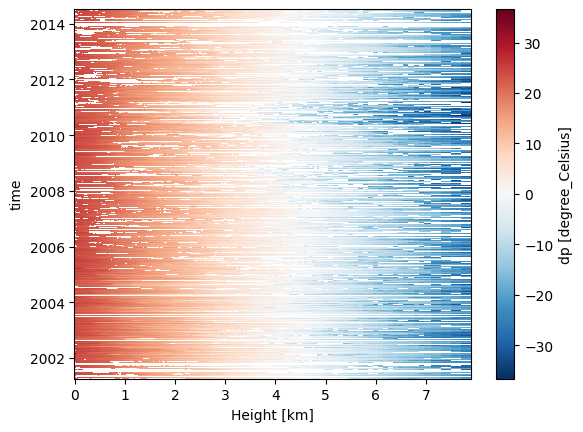

In [93]:
dset_sub['dp'].plot()

In [82]:



#parcel_pro = parcel_profile(pres, temp[0], dew_point[0]).to('degC')

# apply the profile over each timestep

def calc_profile(temp, dew_point, pres):
    bottom_temp = temp[0]
    bottom_dp = dew_point[0]
    return parcel_profile(pres, bottom_temp, bottom_dp).to('degC')

parcel_profile = dset_sub.groupby('time').apply(lambda x: calc_profile(x['temp'], x['dp'], x['bar_pres'])).compute()








ValueError: array must not contain infs or NaNs

In [94]:
client.close()